## FINM 33165 (Autumn 2023) - Assignment 1

* Yumeng Zhang (12372205)
* ymzhang@uchicago.edu

I referred to the code in Pyro SVI.ipynb notebook.

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import scipy.stats
from torch.distributions import constraints
import random
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta,AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete

from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#### **Introduction**

In this assignment, we are going to use **Gaussian Mixture Model (GMM)** to estimate the probability distribution of a dataset, by representing the distribution as a weighted sum of multiple Gaussian distributions.

After loading the dataset, I'm going to use two methods to determine the number of components in the GMM model. Firstly I'm going to guess, and train the model to get MAP parameters, checking if they are reasonable. After that, I'll further use Elbow Method to find out the optimal number of components.

To check if my solution fits the histogram of the dataset, I'm going to plot the GMM estimated density after determining the optimal number of components.

#### **Load the Dataset**

In [2]:
df =  pd.read_pickle(r'data_set 1.zip')

In [3]:
df

,data
0,0.205676
1,0.575321
2,1.346189
3,-2.107491
4,0.237493
...,...
19995,2.239438
19996,0.032034
19997,-0.980857
19998,0.591560


In [4]:
data = torch.tensor(list(df['data']))

Plot the histogram of the dataset, also the kernel density estimation (KDE), which is an estimation of its underlying distribution.

In [5]:
def plot_kde(df):

    plt.rcParams["figure.figsize"] = (22,12)

    ax = df['data'].plot.hist(bins = 300, density = True, edgecolor = 'w', linewidth = 2.5, alpha=0.7, label = "Original Data")

    xlim = ax.get_xlim()

    df['data'].plot.density(color = 'green', linewidth = 2, alpha = 1, ax = ax, label = "KDE Density") 

    ax.set_xlim(xlim)
    # ax.legend(labels = ['KDE'], frameon=False)
    ax.set_title('Histogram Overlaid with KDE', fontsize = 18, pad = 15)

    plt.legend()
    plt.grid(True)
    plt.show()

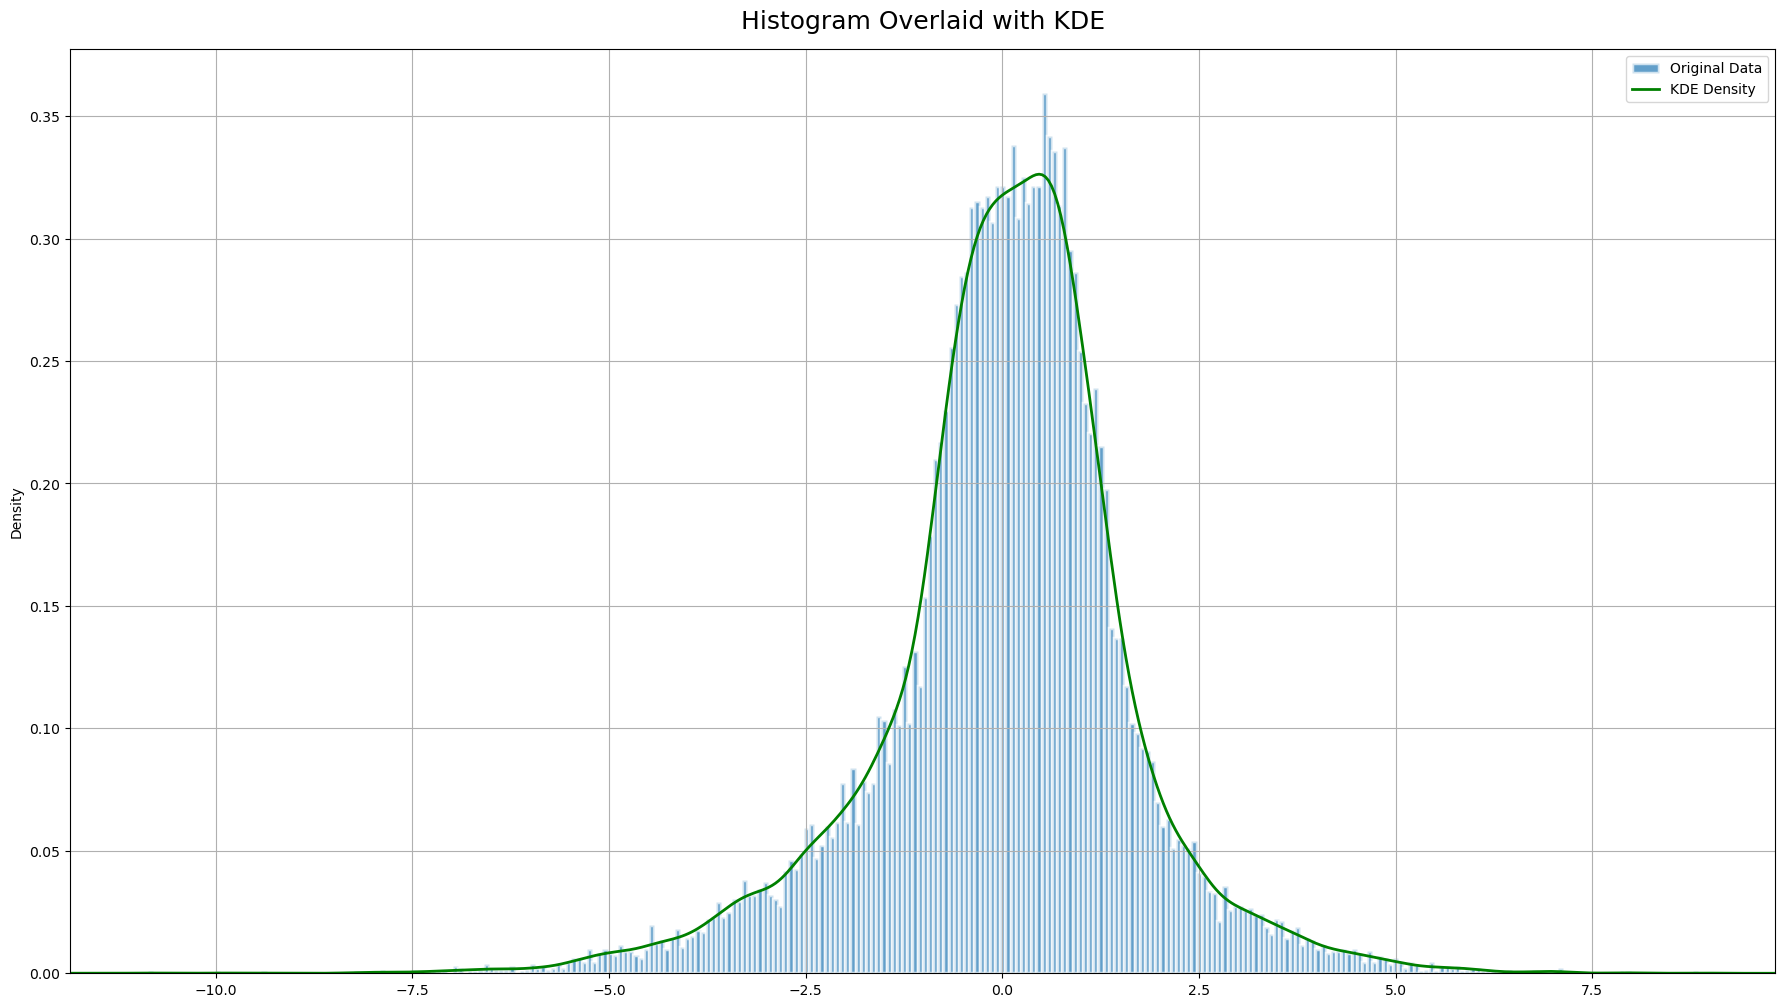

In [6]:
plot_kde(df)

#### **Fit the GMM Model**

To train a GMM model, we need to firstly estimate the number of components. Here I made a guess of 2. Here I'm going to use two ways to determine the number of components used in the GMM model.

1. Firstly, I'm going to guess the number of components, and check the **weights** in MAP parameters to see if my guess is reasonable.

2. After that, I'll use Elbow Method and calculate BIC (Bayesian Information Criterion) to check again if my guess in the first step is correct.

##### **Method 1 - Guess the Number of Components**

* **K = 2**

The first guess is that, in this GMM model, the number of components should be 2.

In [7]:
# number of components

K = 2

In [8]:
# define the pyro model

@config_enumerate
def model(data):
    
    samples = []

    weights=pyro.sample('weights',dist.Dirichlet(0.5 * torch.ones(K)))
    
    with pyro.plate('components',K):

        locs = pyro.sample('locs',dist.Normal(0.,10.))  # the prior distriburion of the means
        scales = pyro.sample('scales',dist.LogNormal(0.,2.))  # the prior distribution of the variances
        
    with pyro.plate('data',len(data)):
        assignment = pyro.sample('assignment',dist.Categorical(weights))
        pyro.sample('obs',dist.Normal(locs[assignment],scales[assignment]),obs=data)     

In [9]:
# initialize the values

def init_loc_fn(site):

    if site['name'] == 'weights':
        return torch.ones(K)/K

    if site['name'] == 'scales':
        return torch.ones(K)

    if site['name'] == 'locs':
        return data[torch.multinomial(torch.ones(len(data))/len(data),K)]
        
    raise ValueError(site['name'])

In [10]:
def train_gmm():

    optim = pyro.optim.Adam({'lr':0.01,'betas':[0.8,0.99]})
    elbo = TraceEnum_ELBO(max_plate_nesting=1)

    # initialize the random number generator
    seed = 325
    pyro.set_rng_seed(seed) 

    # clear out any previous values that might still be stored
    pyro.clear_param_store() 
        
    # define the Variational Distribution as a DElta function
    guide = AutoDelta(poutine.block(model, expose=['weights','locs','scales']), init_loc_fn =  init_loc_fn)

    svi = SVI(model, guide, optim, loss=elbo)

    # run the training loop

    losses = []

    for i in tqdm(range(5000)):

        loss = svi.step(data)
        losses.append(loss)

    return guide, losses

In [11]:
def plot_losses(losses):

    plt.figure(figsize=(20,6), dpi=100).set_facecolor('white')
    plt.plot(losses)
    plt.xlabel('iters')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.title('Convergence of SVI')

In [12]:
# train the GMM model with K = 2

guide, losses = train_gmm()

100%|██████████| 5000/5000 [00:36<00:00, 137.35it/s]


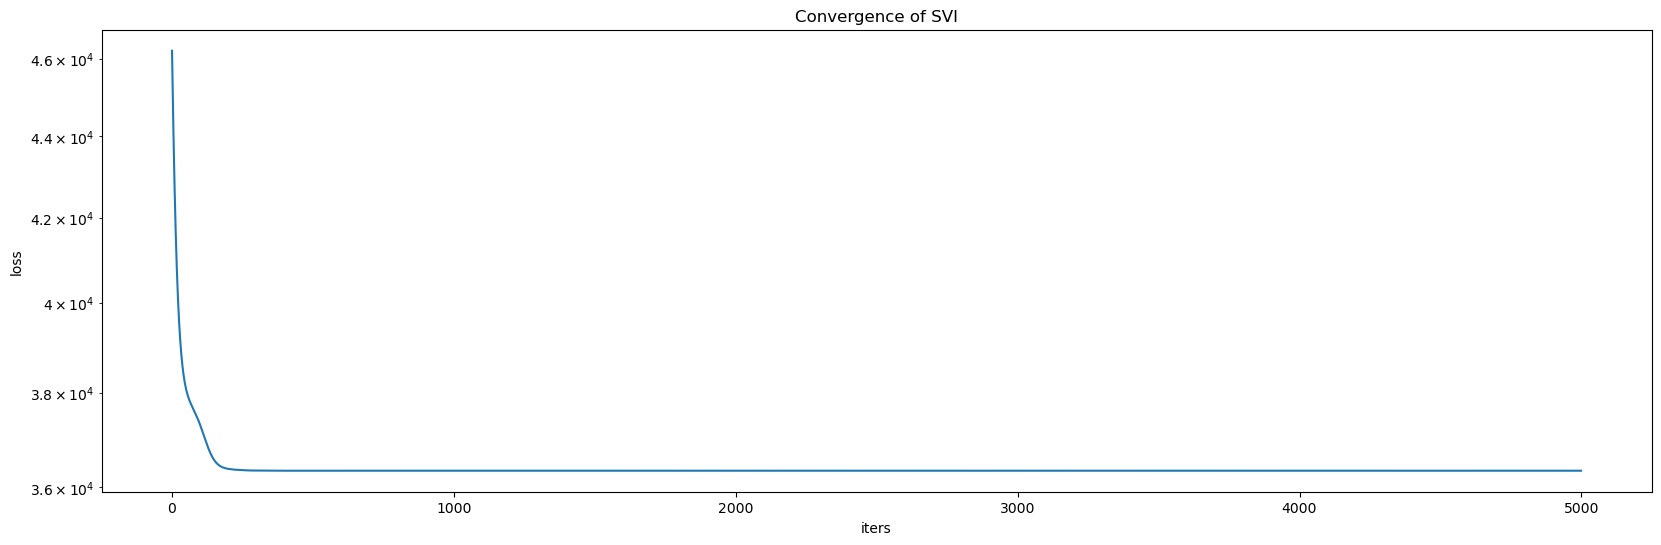

In [13]:
plot_losses(losses)

According to the above plot, the training of SVI converged.

In [14]:
# MAP parameters 

map_estimates = guide(data)

weights = map_estimates['weights']
locs = map_estimates['locs']
scales = map_estimates['scales']

print("number of components = ", K)
print(" ")
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scales = {}'.format(scales.data.numpy()))

number of components =  2
 
weights = [0.5815397 0.4184603]
locs = [ 0.24023014 -0.26301974]
scales = [0.8249258 2.2392592]


* **K = 3**

In [15]:
# train the GMM model with K = 3

K = 3
guide_, losses_ = train_gmm()

100%|██████████| 5000/5000 [00:37<00:00, 134.03it/s]


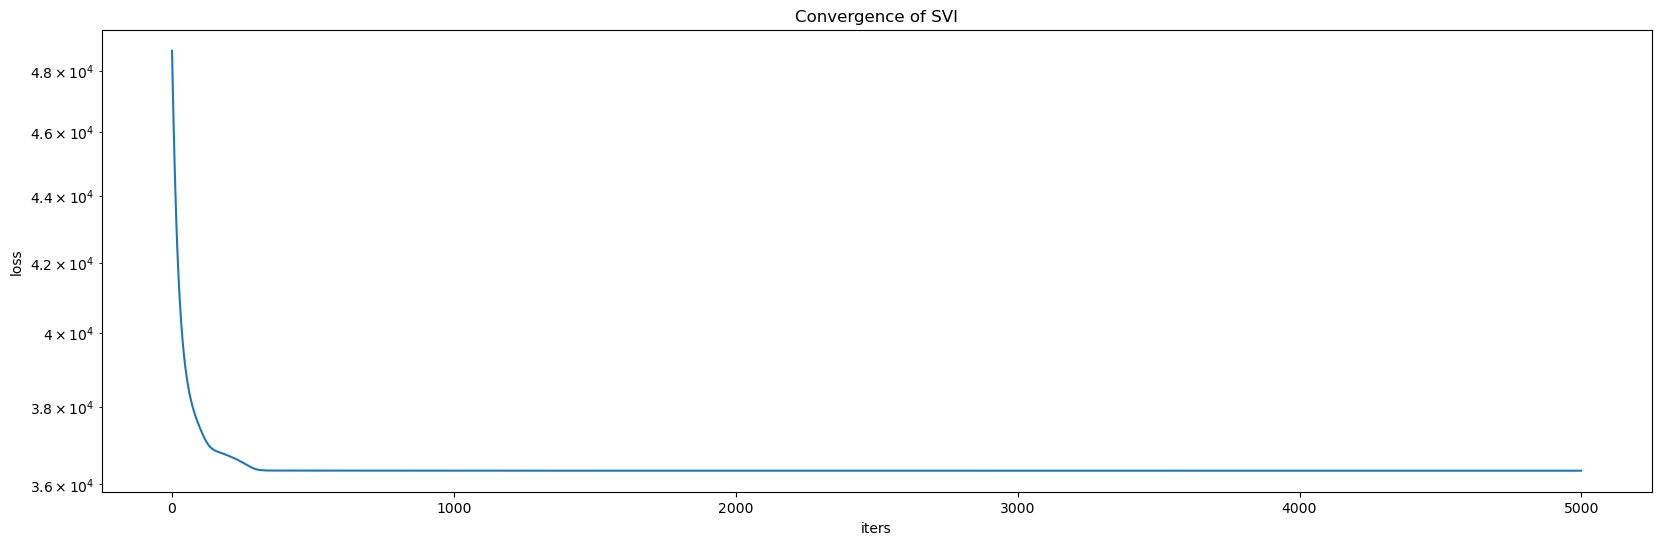

In [16]:
plot_losses(losses_)

In [17]:
map_estimates_ = guide_(data)

weights_ = map_estimates_['weights']
locs_ = map_estimates_['locs']
scales_ = map_estimates_['scales']

print("number of components = ", K)
print(" ")
print('weights = {}'.format(weights_.data.numpy()))
print('locs = {}'.format(locs_.data.numpy()))
print('scales = {}'.format(scales_.data.numpy()))

number of components =  3
 
weights = [0.5651138  0.42352843 0.01135777]
locs = [ 0.24409515 -0.23082936 -0.90012187]
scales = [0.8137689 2.1638448 3.4737282]


According to the above results, we could see that when the number of components equals 3, the training losses still converged. However, in the MAP parameters, one of the weights (0.00113578) is very small comparing with the weights of other two components. Since the weight is close to 0, I believe that this component is unnessary, and **setting the number of components to be 2 should be the most reasonable**.

In the following analysis, I'm going to use Elbow Method to prove that my guess is correct.

##### **Method 2 - Use Elbow Method to Determine the Number of Components**

In [18]:
data_np = data.numpy().reshape(-1,1)

n_components_range = range(1, 11)  

bic_values = []

for n_components in n_components_range:

    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_np)  
    bic = gmm.bic(data_np)  
    bic_values.append(bic)

In [19]:
# find the optimal number of components with the lowest BIC
optimal_n_components = n_components_range[np.argmin(bic_values)]

print("the optimal number of components: ", optimal_n_components)

the optimal number of components:  2


According to the above results, by finding the lowest value of BIC (Bayesian Information Criterion), for the GMM model to estimate the probability density of this dataset, the optimal number of components should be 2, and my estimation was correct.

In the following analysis, I'm going to use the MAP parameters (K = 2) to estimate the density, and plot the estimated density against the histogram of the dataset to see if the estimation fits the actual distribution.

#### **Plot the Density Function**

In [20]:
# use MAP parameters to calculate the estimated density

weights = weights.detach().numpy()
locs = locs.detach().numpy()
scales = scales.detach().numpy()
# weights = weights_.detach().numpy()
# locs = locs_.detach().numpy()
# scales = scales_.detach().numpy()

estimated_density = np.zeros_like(data, dtype=float)

for weight, loc, scale in zip(weights, locs, scales):

    component_pdf = scipy.stats.norm(loc=loc, scale=scale).pdf(data)
    estimated_density += weight * component_pdf

In [21]:
df['estimated_density'] = estimated_density
df = df.sort_values(by='data')

In [22]:
def plot_estimated_density(df):

    plt.rcParams["figure.figsize"] = (22,12)

    ax = df['data'].plot.hist(bins = 300, density = True, edgecolor = 'w', linewidth = 2.5, alpha=0.7, label="Original Data")

    xlim = ax.get_xlim()

    df['data'].plot.density(color = 'green', alpha = 1, ax = ax, linewidth = 2, label="KDE Density") 

    plt.plot(df['data'], df['estimated_density'], color='orange', linewidth = 2, label="GMM Estimated Density")

    ax.set_xlim(xlim)
    # ax.legend(labels = ['KDE'], frameon=False)
    ax.set_title('Histogram Overlaid with GMM Estimated Probability Density', fontsize = 18, pad = 15)

    plt.legend()
    plt.grid(True)
    plt.show()

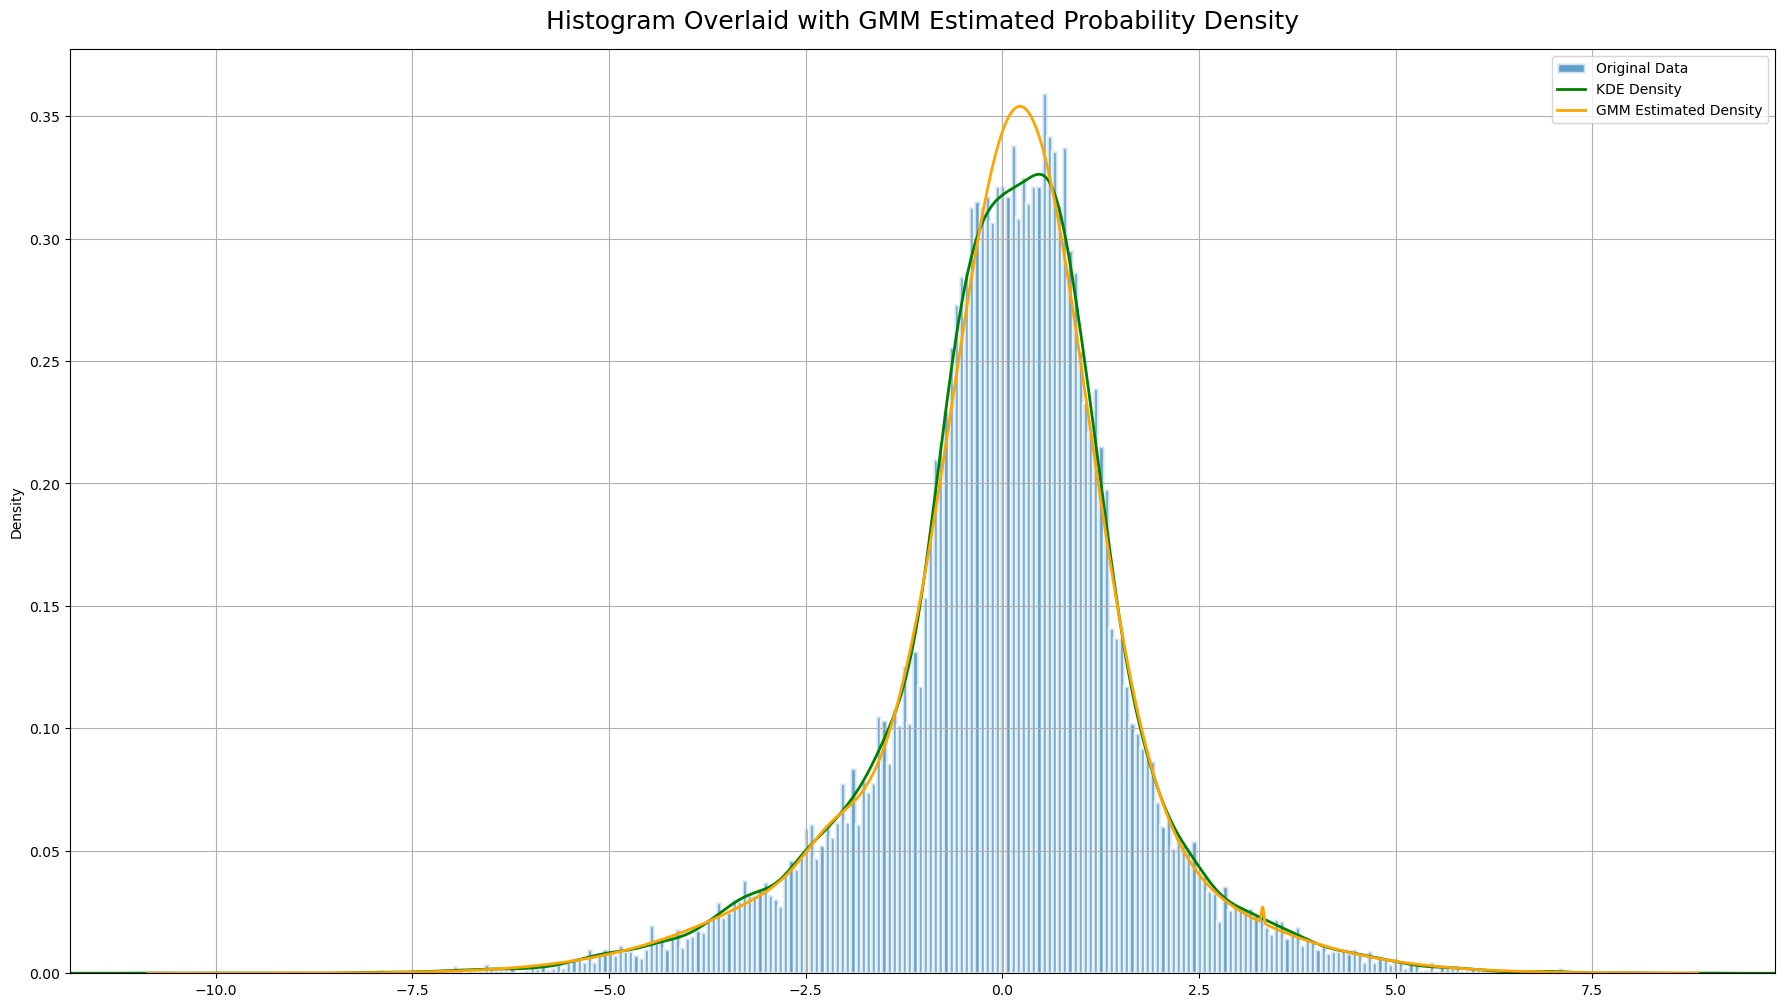

In [23]:
plot_estimated_density(df)

By plotting the histogram of dataset, also the GMM estimated density function, we could say that **my solution fits the histogram of the data very well**. Also, the GMM estimated density is similar to KDE.

#### **Conclusion**

In this assignment, I found that the optimal number of components for the GMM model was 2 by using two methods. After I trained the model and got the MAP parameters, I plotted the density function against the histogram found that the solution fitted the dataset very well.